In [26]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Import estimators and transformers
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.compose import ColumnTransformer
from src.features import CustomEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import PowerTransformer
from sklearn.compose import TransformedTargetRegressor

# Import predictors
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.model_selection import GridSearchCV

# Import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score, cross_val_predict

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

%load_ext autoreload
%autoreload 2

path_processed = '/home/matteo@COPPET/Documents/data_science/projects/housing_prices_firenze/data/processed/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
df = pd.read_csv(path_processed+'data_clean.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8714 entries, 0 to 8713
Data columns (total 57 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Tipologia                                  8714 non-null   object 
 1   Tipo_proprietà                             8277 non-null   object 
 2   Zona                                       8714 non-null   object 
 3   Anno_costruzione                           6334 non-null   float64
 4   Stato                                      8483 non-null   object 
 5   Prezzo_EUR                                 8714 non-null   float64
 6   Superficie_m2                              8714 non-null   float64
 7   Prezzo_per_m2                              8714 non-null   float64
 8   Riscaldamento_A_C                          8714 non-null   object 
 9   Tipo_riscaldamento                         6760 non-null   object 
 10  Alimentazione_riscaldame

In [3]:
df['Prezzo_EUR'].describe()

count       8714.000
mean      481863.318
std       659474.582
min          700.000
25%       248000.000
50%       339000.000
75%       501000.000
max     28000000.000
Name: Prezzo_EUR, dtype: float64

array([[<AxesSubplot:title={'center':'Prezzo_EUR'}>]], dtype=object)

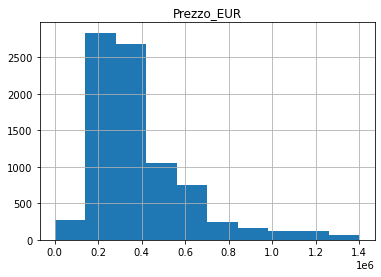

In [115]:
df[['Prezzo_EUR']].hist()

<AxesSubplot:>

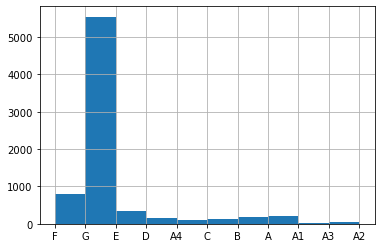

In [4]:
df['Classe_energetica'].hist()

<AxesSubplot:>

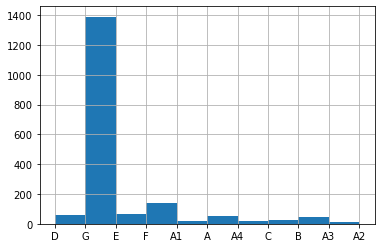

In [5]:
df.loc[df['Anno_costruzione'].isna(), 'Classe_energetica'].hist()

### 1. Outliers

In [113]:
# Remove all rows containing outliers in either Price or Square meters by using z statistic
df = df.loc[(np.abs(stats.zscore(df[['Prezzo_EUR', 'Superficie_m2']])) < 3).all(axis=1)]

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8604 entries, 0 to 8713
Data columns (total 57 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Tipologia                                  8604 non-null   object 
 1   Tipo_proprietà                             8174 non-null   object 
 2   Zona                                       8604 non-null   object 
 3   Anno_costruzione                           6265 non-null   float64
 4   Stato                                      8378 non-null   object 
 5   Prezzo_EUR                                 8604 non-null   float64
 6   Superficie_m2                              8604 non-null   float64
 7   Prezzo_per_m2                              8604 non-null   float64
 8   Riscaldamento_A_C                          8604 non-null   object 
 9   Tipo_riscaldamento                         6684 non-null   object 
 10  Alimentazione_riscaldame

### 1. Feature selection and splitting data

In [92]:
target = 'Prezzo_EUR'
#drop_cols = ['Prezzo_per_m2', 'Anno_costruzione', 'Tipo_riscaldamento', 'Alimentazione_riscaldamento',
#             'Classe_energetica'] + [target]

drop_cols = ['Prezzo_per_m2'] + [target]

X = df.drop(columns=drop_cols)
y = np.log1p(df[target].values)
#y = df[target].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### 2. Pre-processing pipeline

In [93]:
cat_features = ['Tipologia', 'Zona', 'Stato', 'Tipo_proprietà', 'Riscaldamento_A_C', 'Tipo_riscaldamento',
                'Alimentazione_riscaldamento', 'Classe_energetica', 'Piano']
num_features = ['Superficie_m2', 'Num_bagni', 'Num_tot_locali', 'Anno_costruzione']

# cat_features = ['Tipologia', 'Zona', 'Tipo_proprietà', 'Tipo_riscaldamento', 'Classe_energetica']
# num_features = ['Superficie_m2', 'Num_tot_locali']

TransformedTargetRegressor()

cat_transformer = Pipeline([
    ('imputing', SimpleImputer(strategy='most_frequent')),
    ('oh_encoding', OneHotEncoder(handle_unknown='ignore'))
])

num_transformer = Pipeline([
    ('transforming', PowerTransformer()),
    ('imputing', SimpleImputer(strategy='mean'))
])

preprocessing_pipeline = ColumnTransformer([
    ('categoricals', cat_transformer, cat_features),
    ('numericals', num_transformer, num_features)
],
    remainder='passthrough'
)

In [106]:
lr = LinearRegression()
lr.fit(X_train['Superficie_m2'].to_numpy().reshape(-1, 1), y_train)
pred = lr.predict(X_train['Superficie_m2'].to_numpy().reshape(-1, 1))
# Train set score
print('Training set score: {}'.format(np.sqrt(mean_squared_error(y_train, y_train_pred))))
#scores = np.sqrt(-cross_val_score(lr, X_train['Superficie_m2'], y_train, scoring=scoring, cv=num_folds))

Training set score: 0.2188341222380089


In [94]:
# predict log(Price)
# MAE vs. RMSE?
# plot true vs. pred values; ordered on the x-axis to see where most errors come from
# imputing with sophisticated algo but choosing the right features
# fit a LR with 2-3 features and use as benchmark if good result (m2, classe energetica)
# classe energetica distributions seem similar ==> use to impute construction year

### 3. Modeling

In [95]:
# Test Options and Evaluation Metrics
num_folds = 10
scoring = "neg_mean_squared_error"

#### 3.1 First model (benchmarking)

In [107]:
pipe = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('model', LinearRegression())
])

pipe.fit(X_train, y_train)
y_train_pred = pipe.predict(X_train)

# Train set score
print('Training RMSE: {}'.format(np.sqrt(mean_squared_error(y_train, y_train_pred))))

# Cross validation score
scores = np.sqrt(-cross_val_score(pipe, X_train, y_train, scoring=scoring, cv=num_folds))
cv_preds = cross_val_predict(pipe, X_train, y_train, cv=num_folds)
print('Mean cross validation RMSE: {}'.format(np.mean(scores)))

Training RMSE: 0.2188341222380089
Mean cross validation RMSE: 1381745244.4076102


In [97]:
y_sorted = np.sort(y_train)
cv_preds_sorted = np.sort(cv_preds)

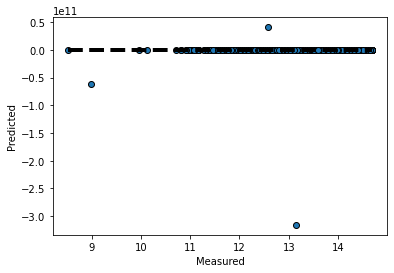

In [110]:
fig, ax = plt.subplots()
ax.scatter(y_train, cv_preds, edgecolors=(0, 0, 0))
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

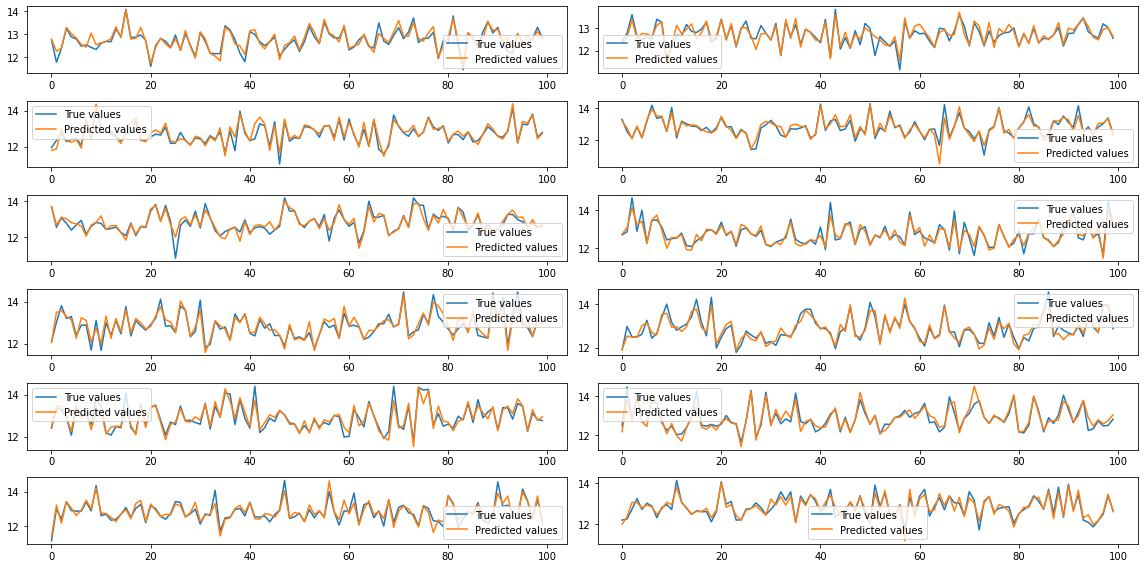

In [109]:
fig = plt.figure(figsize=(16, 8))
j = 1
for i in range(12):
    plt.subplot(6, 2, j)
    plt.plot(y_train[i*100:(i+1)*100])
    plt.plot(cv_preds[i*100:(i+1)*100])
    plt.legend(['True values', 'Predicted values'])
    plt.tight_layout()
    j += 1

#### 3.2 Other models

In [12]:
# Define algorithms
models = []
models.append(('Ridge', Ridge()))
models.append(('EN', ElasticNet()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('RDMF', RandomForestRegressor(random_state=0)))
models.append(('EXTR', ExtraTreesRegressor(random_state=0)))
models.append(('GBOO', GradientBoostingRegressor(random_state=0)))
models.append(('ADA', AdaBoostRegressor(random_state=0)))

train_results = []
test_results = []
names = []
for name, model in models:
    #kfold = KFold(n_splits=num_folds, random_state=seed)
    pipe = Pipeline([
        ('preprocessing', preprocessing_pipeline),
        ('model', model)
    ])
    # Train score
    pipe.fit(X_train, y_train)
    y_train_pred = pipe.predict(X_train)
    train_res = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_results.append(train_res)

    # Test score
    cv_results = np.sqrt(-cross_val_score(pipe, X_train, y_train, scoring=scoring, cv=num_folds))
    test_results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" %(name, np.mean(cv_results),   np.std(cv_results))
    print(msg)

Ridge: 0.226451 (0.026537)
EN: 0.590525 (0.015967)
CART: 0.294670 (0.030332)
RDMF: 0.221317 (0.027277)
EXTR: 0.220599 (0.025640)
GBOO: 0.227001 (0.024555)
ADA: 0.304045 (0.015910)


The results are much better when removing outliers from the data!

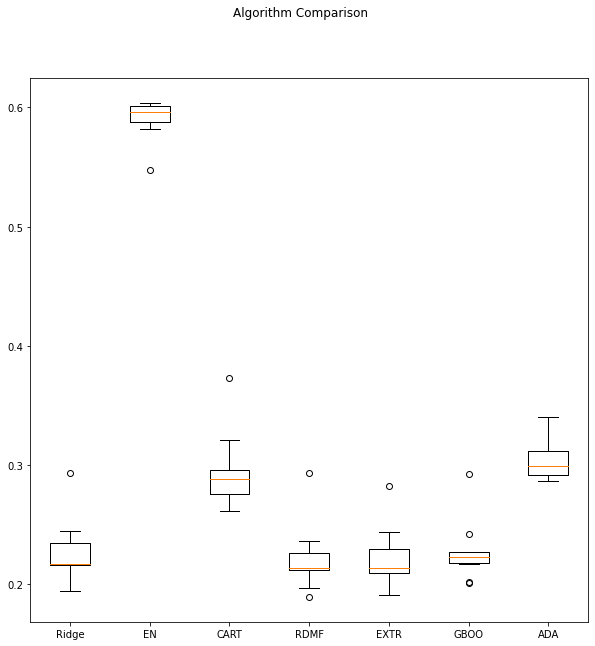

In [16]:
# Compare Algorithms
fig = plt.figure(figsize=(10, 10))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(test_results)
#plt.scatter(x=names[:-1], y=train_results[:-1])
ax.set_xticklabels(names)
plt.show()

### 4. Hyperparameter tuning

In [ ]:
pipe = Pipeline([
    ('preprocessin# Extra-Trees
pipe = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('model', ExtraTreesRegressor(random_state=0))
])

pipe.fit(X_train, y_train)
y_train_pred = pipe.predict(X_train)

# Train set score
print('Training set score: {}'.format(mean_absolute_error(y_train, y_train_pred)))

# Cross validation score
scores = cross_val_score(pipe, X_train, y_train, scoring='neg_mean_absolute_error', cv=10)
print('Mean cross validation score: {}'.format(np.mean(-scores)))g', preprocessing_pipeline),
    ('model', ExtraTreesRegressor(random_state=0))
])

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 500, num = 4)]
# Number of features to consider at every split
max_features = [2, 3, 4]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 5)]
max_depth.append(None)
# Split criterion
criterion = ['mse', 'mae']
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
#param_grid = {'n_estimators': n_estimators,
#               'max_features': max_features,
#               'max_depth': max_depth,
#               'criterion': criterion,
#               'min_samples_split': min_samples_split,
#               'min_samples_leaf': min_samples_leaf,
#               'bootstrap': bootstrap}

param_grid = {
    'model__n_estimators': [100, 200, 300, 400],
    'model__max_features': [2, 4, 8],
    'model__min_samples_split': [2, 4, 6],
    'model__min_samples_leaf': [1, 2, 4]
}


grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)

cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(-mean_score, params)

In [ ]:
grid_search.best_params_

In [ ]:
pipe = grid_search.best_estimator_

pipe.fit(X_train, y_train)
y_train_pred = pipe.predict(X_train)

# Train set score
print('Training set score: {}'.format(mean_absolute_error(y_train, y_train_pred)))

# Cross validation score
scores = cross_val_score(pipe, X_train, y_train, scoring='neg_mean_absolute_error', cv=10)
print('Mean cross validation score: {}'.format(np.mean(-scores)))